In [8]:
from docx import Document #library to read .doc and .docx files into the enviornment
import pandas as pd #data processing library
from nltk.stem.porter import PorterStemmer #importing Stemmatizer
from nltk.stem.wordnet import WordNetLemmatizer #importing Lemmatizer
import re
import nltk
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
import os
from os import path
from os import listdir
from os.path import isfile, join
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
import sqlite3
% matplotlib inline

In [9]:
def table_extractor(table):
    # creating dictionary that holds the values found in the table
    keys = None 
    for i, row in enumerate(table.rows):
        text = (cell.text for cell in row.cells)

        if i == 0:
            keys = tuple(text)
            continue
        row_data = dict(zip(keys, text))


    #manipulating the dictionary to allow easier and more comperhensive key word   
    skils_n_lang = [row[1] for row in row_data.items()]
    elements = []
    for row in skils_n_lang:
        row = row.split("\n")
        elements.append(row)
    final_skills = []
    for sublist in elements:
        for item in sublist:
            final_skills.append(item)
    return final_skills

In [26]:
def corpus_extractor(sub_set):
    
    corpus = []
    for i in sub_set['sentence']:
        #Remove punctuations
        text = re.sub('[^a-zA-Z]', ' ', i)

        text = re.sub(" \d+", " ", text)

        #Convert to lowercase
        text = text.lower()

        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text) #explain what re is - regular expressions

        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text) #explain what re is - regular expressions

        ##Convert to list from string
        text = text.split()

        #Lemmatisation
        lem = WordNetLemmatizer() #explain what Lemmatization is. 
        text = " ".join(text) #join the different lists into a string
        corpus.append(text) #append the string to the corpus list

    if len(corpus) == 0:
        return []
    else:
        #creating a vector of word counts
        cv=CountVectorizer(max_df=0.8, max_features=10000, ngram_range=(1,3)) #CountVectorizer
        X=cv.fit_transform(corpus)
        
        #we transform the vector of word counts into a matrix of intergers
        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(X)

        # print idf values
        df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])

        # sort ascending
        return list(df_idf.index)

In [21]:
def converter(word_doc):
    
    #reading the .docx Document
    document = Document(word_doc)
    
    #extracting the paragraphs from the document object we just created
    test_list = [str(row.text.strip()) for row in document.paragraphs]

    #removing blank_spaces("")
    while("" in test_list): 
        test_list.remove("")

    name = test_list[0] #Grabbing the first line of the list which holds the name value
    
    #Converting the reminder of rows into a dataframe with two columns: 
        #one index[n = number of lines in the CV] 
        #one holding a sentence for that respective line
    dataset = pd.DataFrame(test_list[1:], columns= ["sentence"])
    

    #getting the index of the 3 different paragraph sections
    i = 0 #setting the iteration value to 0 
    dicts = dict() #creating an empty dictionary
    drop_idx = [] #creating an empty list
    
    for row in dataset["sentence"]: #starting a loop which looks through each row in the info column
        i += 1 #increase the iteration value by 1
        if row == "Previous Experience" or row == "Education and Certifications" or row == "Skills": #identifiying the rows at the start of each new section
            dicts[row] = i #getting the index for those precise rows
        elif row == "Key Achievements": #identifiying a common 
            drop_idx.append(i-1)
        else:
            pass
    
    idx = [i-1 for i in dicts.values()]
    dataset = dataset.drop(drop_idx)
    
    #checking if there are tables in the document object:
    lst_skills = []
    tables = document.tables
    if len(tables) >= 1: #if table is present we call table_extractor function
        for i in range(len(tables)):
            lst = table_extractor(tables[i]) #call table_extractor
            lst_skills.extend(lst)
    
    return dataset, idx , list(dicts.keys()), lst_skills, name


In [49]:
def corpus_redacter(dataset,idx, keys, table_skills,name):
    candidate = dict()
    word_lst = []
    
    #loop through the subsets
    for i in range(len(idx)):
        if i == 2:
            word_lst.extend(table_skills) #extend list of keywords with table skills if there are any
        else:
            sub_set = dataset[idx[i] :idx[i+1]] #extract sub-section thanks to idx list
            word_lst.extend(corpus_extractor(sub_set)) #run corpus_extractor function on subset onject

    word_lst = list(pd.Series(word_lst).drop_duplicates()) #removing duplicates
    candidate[name] = " ".join(word_lst) #join all the values of the list into a single string and append it to the candidate key = name
    return candidate

In [50]:
dataset, idx, keys, table_skills, name = converter("test1.docx")
candidate= corpus_redacter(dataset, idx, keys, table_skills,name)

In [23]:
def sql_update_table_creator():
    
    path = os.getcwd() #find the path to its current directory
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))] #get only the text name of the files and their "." extentision

    #create three empty lists to hold the values we want to extract from each .docx document
    names = []
    emails = []
    keywords = []
    
    for row in onlyfiles:
        find = ".docx"
        if find in row:
            dataset, idx, keys, table_skills, name = converter(row)
            candidate = corpus_redacter(dataset, idx, keys, table_skills,name)
            person = list(candidate.keys())[0]
            names.append(person)
            email = person.replace(" ", ".").lower() + "@replgroup.com"
            emails.append(email)
            keyword = candidate[name]
            keywords.append(keyword)
        else:
            pass
        
    df = pd.DataFrame(names, columns = ["name"])
    df["email"] = emails
    df["keywords"] = keywords
    
    return df

In [54]:
df = sql_update_table_creator()

,name,email,keywords
0,Kseniya Kamen,kseniya.kamen@replgroup.com,ability ability to ability to work account acc...
1,Matthew Gould,matthew.gould@replgroup.com,achievements across across the across the vari...


## Database creation

In [55]:
DB = "mlb.db"

def run_query(q):
    with sqlite3.connect(DB) as conn:
        return pd.read_sql(q,conn)
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [56]:
tables = {
    "candidates": df,
}

with sqlite3.connect(DB) as conn:    
    for name, data in tables.items():
        conn.execute("DROP TABLE IF EXISTS {};".format(name))
        data.to_sql(name,conn,index=False)

In [57]:
show_tables()

,name,type
0,candidates,table


In [70]:
word = "bp"
q = "SELECT * FROM candidates C WHERE C.keywords LIKE '%{}%';".format(word)


run_query(q)

,name,email,keywords
0,Matthew Gould,matthew.gould@replgroup.com,achievements across across the across the vari...


# Pre-processing the data

In [29]:
# reading the raw data
document = Document("test.docx")
for row in document.paragraphs:
    print(row.text)

Kseniya Kamen
Graduate Consultant at Technical Department of REPL


Previous Experience 
Jo Malone, London: Russian Language Interpreter 
(May 2018 - June 2018)
Key Achievements: 
Assisting Global Stylist of the Year and participating in workshops and presentations for English-to-Russian translations

Kylin Prime Group (The Chinese Weekly), London: PR and Marketing Intern
(January 2018 – April 2018)
Key Achievements: 
Assisting with marketing campaigns and managing social media platforms
Creating, scheduling and managing posts across multiple social media platforms 
Writing, editing and generating ideas for social media content, account maintenance and profile updates.

Ferver Consultancy, London: Intern
(June 2017 – August 2017)
Key Achievements: 
Social media management and content creation
Self-motivation and ability to work independently to assigned projects

Education and Certifications
Queen Mary University of London, Computing and Information Systems MSc (September 2018 – Presen

In [30]:
#converting the data
test_list = [str(row.text.strip()) for row in document.paragraphs]
while("" in test_list): 
    test_list.remove("")

clean_lst = []
for row in test_list:
    row = row.replace("(", "")
    row = row.replace(")", "")
    row = row.replace(".", "")
    row = row.replace(":", "")
    row = row.replace(",", "")
    row = row.replace("•", "")
    row = row.replace("  ", " ")
    row = row.strip()
    clean_lst.append(row)
name = test_list[0]
dataset = pd.DataFrame(clean_lst[1:], columns= ["info"])

In [31]:
dataset

,info
0,Graduate Consultant at Technical Department of...
1,Previous Experience
2,Jo Malone London Russian Language Interpreter
3,May 2018 - June 2018
4,Key Achievements
5,Assisting Global Stylist of the Year and parti...
6,Kylin Prime Group The Chinese Weekly London PR...
7,January 2018 – April 2018
8,Key Achievements
9,Assisting with marketing campaigns and managin...


In [37]:
#getting the index of the 3 different paragraph sections
i = 0
dicts = dict()
drop_idx = []
for row in dataset["info"]:
    i += 1
    if row == "Previous Experience" or row == "Education and Certifications" or row == "Skills":
        dicts[row] = i
    elif row == "Key Achievements":
        drop_idx.append(i-1)
    else:
        pass
print(dicts)
idx = [i for i in dicts.values()]
idx

{'Previous Experience': 2, 'Education and Certifications': 18, 'Skills': 25}


[2, 18, 25]

In [6]:
dataset = dataset.drop(drop_idx)

In [7]:
dataset[idx[0] :idx[1]]

,info
2,Jo Malone London Russian Language Interpreter
3,May 2018 - June 2018
5,Assisting Global Stylist of the Year and parti...
6,Kylin Prime Group The Chinese Weekly London PR...
7,January 2018 – April 2018
9,Assisting with marketing campaigns and managin...
10,Creating scheduling and managing posts across ...
11,Writing editing and generating ideas for socia...
12,Ferver Consultancy London Intern
13,June 2017 – August 2017


In [20]:
dataset[idx[2]:]

,info


In [8]:
#splitting the data into the  subset
sub_data_past = dataset[idx[0] :idx[1]]
sub_data_achiv = dataset[idx[1]:idx[2]]
sub_data_skills = dataset[idx[2]:]
if len(sub_data_skills) == 0:
    print("Skills are collected in table format. We will ignore this subset")

Skills are collected in table format. We will ignore this subset


In [9]:
sub_data_past.head(10)

,info
2,Jo Malone London Russian Language Interpreter
3,May 2018 - June 2018
5,Assisting Global Stylist of the Year and parti...
6,Kylin Prime Group The Chinese Weekly London PR...
7,January 2018 – April 2018
9,Assisting with marketing campaigns and managin...
10,Creating scheduling and managing posts across ...
11,Writing editing and generating ideas for socia...
12,Ferver Consultancy London Intern
13,June 2017 – August 2017


In [10]:
sub_data_achiv.head(10)

,info
21,Westminster University Public Relations and Ad...
22,Academic Grade 21 Upper Second Class Honours
23,Modules Professional Practice & Employability ...
24,Skills


In [11]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))

#Creating a list of custom stopwords
new_words = ["using","january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
stop_words = stop_words.union(new_words)

In [12]:
corpus = []
for i in sub_data_achiv['info']:
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', i)
    
    text = re.sub(" \d+", " ", text)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [13]:
corpus

['westminster university public relation advertising ba',
 'academic grade upper second class honour',
 'module professional practice employability pr advertising global practice issue pr advertising online advertising public relation campaigning persuasive skill public relation advertising theory medium communication',
 'skill']

In [14]:
corpus_1 = []
for i in sub_data_past['info']:
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', i)
    
    text = re.sub(" \d+", " ", text)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    
    ##Stemming
    ps=PorterStemmer()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus_1.append(text)

In [15]:
corpus_1

['jo malone london russian language interpreter',
 '',
 'assisting global stylist year participating workshop presentation english russian translation',
 'kylin prime group chinese weekly london pr marketing intern',
 '',
 'assisting marketing campaign managing social medium platform',
 'creating scheduling managing post across multiple social medium platform',
 'writing editing generating idea social medium content account maintenance profile update',
 'ferver consultancy london intern',
 '',
 'social medium management content creation',
 'self motivation ability work independently assigned project',
 'education certification',
 'queen mary university london computing information system msc present',
 'module information system computer programming java database system sqlite postgresql security authentication cloud computing interactive system design bayesian decision risk analysis agenarisk',
 'acquired skill principle component dbms implementation database object relational databas

In [16]:
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [17]:
list(cv.vocabulary_.keys())[:10]

['westminster',
 'university',
 'public',
 'relation',
 'advertising',
 'ba',
 'westminster university',
 'university public',
 'public relation',
 'relation advertising']

In [26]:
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.index

Index(['academic', 'academic grade', 'academic grade upper', 'advertising',
       'advertising ba', 'advertising global', 'advertising global practice',
       'advertising online', 'advertising online advertising',
       'advertising public', 'advertising public relation',
       'advertising theory', 'advertising theory medium', 'ba', 'campaigning',
       'campaigning persuasive', 'campaigning persuasive skill', 'class',
       'class honour', 'communication', 'employability', 'employability pr',
       'employability pr advertising', 'global', 'global practice',
       'global practice issue', 'grade', 'grade upper', 'grade upper second',
       'honour', 'issue', 'issue pr', 'issue pr advertising', 'medium',
       'medium communication', 'module', 'module professional',
       'module professional practice', 'online', 'online advertising',
       'online advertising public', 'persuasive', 'persuasive skill',
       'persuasive skill public', 'pr', 'pr advertising',
       'pr a

In [18]:
cv_1=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X_1=cv_1.fit_transform(corpus_1)

In [19]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X_1)
# print idf values
df_idf_1 = pd.DataFrame(tfidf_transformer.idf_, index=cv_1.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf_1.sort_values(by=['idf_weights'])

,idf_weights
social,2.223775
social medium,2.223775
london,2.223775
medium,2.223775
system,2.446919
programming,2.734601
database,2.734601
social medium platform,2.734601
computer,2.734601
medium platform,2.734601


# Table manipulation

- Say that there is a difference in format across the CVs sent by the employees
- Explain what is the difference (tables vs cvs without tables)
- Show screenshoot of your table
    - screenshot here
    
- Solution: is the above-written function
    1. First we transform table into a dictionary 
    2. We extract the values from the dictionary and create a list of keywords

In [20]:
# ready tables
table = document.tables[0]

# creating dictionary that holds the values
keys = None
for i, row in enumerate(table.rows):
    text = (cell.text for cell in row.cells)

    if i == 0:
        keys = tuple(text)
        continue
    row_data = dict(zip(keys, text))

    
#manipulating the data structure to allow easier and more comperhensive key word   
skils_n_lang = [row[1] for row in row_data.items()]
elements = []
for row in skils_n_lang:
    row = row.split("\n")
    elements.append(row)
final_skills = []
for sublist in elements:
    for item in sublist:
        final_skills.append(item)

print(final_skills)

['Java', 'MySQL', 'Microsoft Office Suit', 'Adobe XD', 'English (Fluent)', 'Russian (Fluent)', 'Greek (Intermediate)']


# Word Cloud

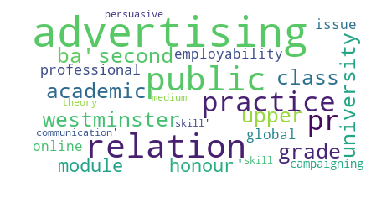

In [40]:
#Word cloud
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

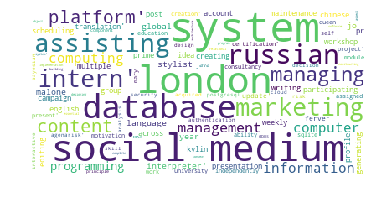

In [41]:
#Word cloud
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus_1))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()